Source https://github.com/yandexdataschool/Practical_DL/blob/fall21/week06_rnn/seminar_pytorch.ipynb

### Generating names with recurrent neural networks

This time you'll find yourself delving into the heart (and other intestines) of recurrent neural networks on a class of toy problems.

Struggle to find a name for the variable? Let's see how you'll come up with a name for your son/daughter. Surely no human has expertize over what is a good child name, so let us train RNN instead;

It's dangerous to go alone, take these:

In [1]:
import io
import numpy as np
import matplotlib.pyplot as plt
import urllib.request

%matplotlib inline

url = 'https://raw.githubusercontent.com/yandexdataschool/Practical_DL/fall19/week06_rnn/names'

with urllib.request.urlopen(url) as url, io.open('names', 'wb') as names_file:
    raw_bytes = url.read()
    names_file.write(raw_bytes)

# Our data
The dataset contains ~8k earthling names from different cultures, all in latin transcript.

This notebook has been designed so as to allow you to quickly swap names for something similar: deep learning article titles, IKEA furniture, pokemon names, etc.

In [2]:
import os
start_token = " "

with open("names") as f:
    lines = f.read()[:-1].split('\n')
    lines = [start_token + line for line in lines]

In [3]:
print ('n samples = ',len(lines))
for x in lines[::1000]:
    print (x)

n samples =  7944
 Abagael
 Claresta
 Glory
 Liliane
 Prissie
 Geeta
 Giovanne
 Piggy


max length = 16


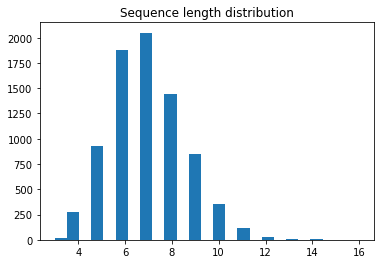

In [4]:
MAX_LENGTH = max(map(len, lines))
print("max length =", MAX_LENGTH)

plt.title('Sequence length distribution')
plt.hist(list(map(len, lines)),bins=25);

# Text processing

**(1 score)** First we need next to collect a "vocabulary" of all unique tokens i.e. unique characters. We can then encode inputs as a sequence of character ids.

In [5]:
#all unique characters go here
tokens = set().union(*lines)

tokens = list(tokens)

num_tokens = len(tokens)
print ('num_tokens = ', num_tokens)

assert 50 < num_tokens < 60, "Names should contain within 50 and 60 unique tokens depending on encoding"

num_tokens =  55


### Convert characters to integers

Torch is built for crunching numbers, not strings. 
To train our neural network, we'll need to replace characters with their indices in tokens list.

**(1 score)** Let's compose a dictionary that does this mapping.

In [6]:
token_to_id = {tokens[i] : i for i in range(len(tokens)) }

In [7]:
assert len(tokens) == len(token_to_id), "dictionaries must have same size"

for i in range(num_tokens):
    assert token_to_id[tokens[i]] == i, "token identifier must be it's position in tokens list"

print("Seems alright!")

Seems alright!


In [8]:
def to_matrix(lines, max_len=None, pad=token_to_id[' '], dtype='int32', batch_first = True):
    """Casts a list of names into rnn-digestable matrix"""
    
    max_len = max_len or max(map(len, lines))
    lines_ix = np.zeros([len(lines), max_len], dtype) + pad

    for i in range(len(lines)):
        line_ix = [token_to_id[c] for c in lines[i]]
        lines_ix[i, :len(line_ix)] = line_ix
        
    if not batch_first: # convert [batch, time] into [time, batch]
        lines_ix = np.transpose(lines_ix)

    return lines_ix

In [9]:
#Example: cast 4 random names to matrices, pad with zeros
print('\n'.join(lines[::2000]))
print(to_matrix(lines[::2000]))

 Abagael
 Glory
 Prissie
 Giovanne
[[36 19 47  4 42  4 14  1 36]
 [36 11  1 53  7 41 36 36 36]
 [36 43  7 25 44 44 25 14 36]
 [36 11 25 53 26  4 22 22 14]]


# Recurrent neural network

We can rewrite recurrent neural network as a consecutive application of dense layer to input $x_t$ and previous rnn state $h_t$. This is exactly what we're gonna do now.
<img src="./rnn.png" width=480>

Since we're training a language model, there should also be:
* An embedding layer that converts character id x_t to a vector.
* An output layer that predicts probabilities of next phoneme

**(4 scores)**

In [10]:
import torch, torch.nn as nn
import torch.nn.functional as F

class CharRNNCell(nn.Module):
    """
    Implement the scheme above as torch module
    """
    def __init__(self, num_tokens=len(tokens), embedding_size=16, rnn_num_units=64):
        super(self.__class__,self).__init__()
        self.num_units = rnn_num_units
        self.embedding = nn.Embedding(num_tokens, embedding_size)
        self.rnn_update = nn.Linear(embedding_size + rnn_num_units, rnn_num_units)
        self.rnn_to_logits = nn.Linear(rnn_num_units, num_tokens)
        
    def forward(self, x, h_prev):
        """
        This method computes h_next(x, h_prev) and log P(x_next | h_next)
        We'll call it repeatedly to produce the whole sequence.
        
        :param x: batch of character ids, int64[batch_size]
        :param h_prev: previous rnn hidden states, float32 matrix [batch, rnn_num_units]
        """
        # get vector embedding of x
        x_emb = self.embedding(x)
        
        # compute next hidden state using self.rnn_update
        # hint: use torch.cat(..., dim=...) for concatenation
        h_next = torch.cat((x_emb, h_prev), dim= 1)
        h_next = self.rnn_update(h_next)
        h_next = torch.tanh(h_next)
        
        assert h_next.size() == h_prev.size()
        
        # compute logits for next character probs
        logits = self.rnn_to_logits(h_next) ### YOUR CODE
        
        return h_next, F.log_softmax(logits, -1)
    
    def initial_state(self, batch_size):
        """ return rnn state before it processes first input (aka h0) """
        return torch.zeros(batch_size, self.num_units)

In [11]:
char_rnn = CharRNNCell()

### RNN loop

Once we've defined a single RNN step, we can apply it in a loop to get predictions on each step.

In [12]:

def rnn_loop(char_rnn, batch_ix):
    """
    Computes log P(next_character) for all time-steps in lines_ix
    :param lines_ix: an int32 matrix of shape [batch, time], output of to_matrix(lines)
    """
    batch_size, max_length = batch_ix.size()
    hid_state = char_rnn.initial_state(batch_size)
    logprobs = []

    for x_t in batch_ix.transpose(0,1):
        hid_state, logp_next = char_rnn(x_t, hid_state)  # <-- here we call your one-step code
        logprobs.append(logp_next)
        
    return torch.stack(logprobs, dim=1)

In [13]:
batch_ix = to_matrix(lines[:5])
batch_ix = torch.tensor(batch_ix, dtype=torch.int64)

logp_seq = rnn_loop(char_rnn, batch_ix)

assert torch.max(logp_seq).data.numpy() <= 0
assert tuple(logp_seq.size()) ==  batch_ix.shape + (num_tokens,)

### Likelihood and gradients

We can now train our neural network to minimize crossentropy (maximize log-likelihood) with the actual next tokens.

To do so in a vectorized manner, we take `batch_ix[:, 1:]` - a matrix of token ids shifted i step to the left so i-th element is acutally the "next token" for i-th prediction

In [14]:
predictions_logp = logp_seq[:, :-1]
actual_next_tokens = batch_ix[:, 1:]

criterion = torch.nn.NLLLoss()

logp_next = torch.gather(predictions_logp, dim=2, index=actual_next_tokens[:,:,None])

loss = -logp_next.mean()

In [15]:
loss.backward()

In [16]:
for w in char_rnn.parameters():
    assert w.grad is not None and torch.max(torch.abs(w.grad)).data.numpy() != 0, \
        "Loss is not differentiable w.r.t. a weight with shape %s. Check forward method." % (w.size(),)

### The training loop

We train our char-rnn exactly the same way we train any deep learning model: by minibatch sgd.

The only difference is that this time we sample strings, not images or sound.

**(4 scores)**

In [17]:
from IPython.display import clear_output
from random import sample

char_rnn = CharRNNCell()
opt = torch.optim.Adam(char_rnn.parameters())
history = []

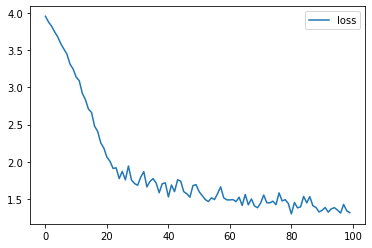

In [19]:
for i in range(1000):
    batch_ix = to_matrix(sample(lines, 32), max_len=MAX_LENGTH)
#     batch_ix = to_matrix(lines[i:i+32], max_len=MAX_LENGTH)
    batch_ix = torch.tensor(batch_ix, dtype=torch.int64)
    logp_seq = rnn_loop(char_rnn, batch_ix)
    logp_seq = logp_seq.permute((0,2,1))
    # compute loss
    # <YOUR CODE>
    target = torch.roll(batch_ix, -1, 1)
    
    loss = criterion(logp_seq, target)
    opt.zero_grad()

    # train with backprop
    # <YOUR CODE>
    loss.backward()
    opt.step()
    
    history.append(loss.data.numpy())
    if (i+1)%100==0:
        clear_output(True)
        plt.plot(history,label='loss')
        plt.legend()
        plt.show()

assert np.mean(history[:10]) > np.mean(history[-10:]), "RNN didn't converge."

### RNN: sampling
Once we've trained our network a bit, let's get to actually generating stuff. 
All we need is the single rnn step function you have defined in `char_rnn.forward`.

In [20]:
def generate_sample(char_rnn, seed_phrase=' ', max_length=MAX_LENGTH, temperature=1.0):
    '''
    The function generates text given a phrase of length at least SEQ_LENGTH.
    :param seed_phrase: prefix characters. The RNN is asked to continue the phrase
    :param max_length: maximum output length, including seed_phrase
    :param temperature: coefficient for sampling.  higher temperature produces more chaotic outputs,
                        smaller temperature converges to the single most likely output
    '''
    
    x_sequence = [token_to_id[token] for token in seed_phrase]
    x_sequence = torch.tensor([x_sequence], dtype=torch.int64)
    hid_state = char_rnn.initial_state(batch_size=1)
    
    #feed the seed phrase, if any
    for i in range(len(seed_phrase) - 1):
        hid_state, _ = char_rnn(x_sequence[:, i], hid_state)
    
    #start generating
    for _ in range(max_length - len(seed_phrase)):
        hid_state, logp_next = char_rnn(x_sequence[:, -1], hid_state)
        p_next = F.softmax(logp_next / temperature, dim=-1).data.numpy()[0]
        
        # sample next token and push it back into x_sequence
        next_ix = np.random.choice(num_tokens,p=p_next)
        next_ix = torch.tensor([[next_ix]], dtype=torch.int64)
        x_sequence = torch.cat([x_sequence, next_ix], dim=1)
        
    return ''.join([tokens[ix] for ix in x_sequence.data.numpy()[0]])

In [21]:
for _ in range(10):
    print(generate_sample(char_rnn))

 ueaeFnnr     ti
 B   i          
             A  
 ioBwy          
     o m        
 Qem u  h ia    
  Iab           
 Mlsr  a yn    l
     a          
 k    l         


In [22]:
for _ in range(50):
    print(generate_sample(char_rnn, seed_phrase=' Trump'))

 Trumpn         
 Trumpn df      
 Trump          
 Trump          
 Trumpatiaur    
 Trumpr N Z     
 Trump     c    
 Trump   d      
 Trumpe         
 Trumpa         
 Trumpn         
 Trump  a       
 Trump          
 Trump  a       
 Trumpr         
 Trump      n   
 Trumpo         
 Trumpaiel      
 Trump          
 Trumphrt       
 Trumpz         
 Trumpse    o   
 Trumpsr        
 TrumpDa    i   
 Trumph         
 Trumpdian     y
 Trumpn  e ne lA
 Trumpii        
 Trumpi         
 Trumpn   a    c
 Trump          
 Trumpr Eaa     
 Trumpedi im a  
 TrumpFl  a  el 
 Trumpr         
 Trumpr         
 Trump          
 Trumpie        
 Trumpnl        
 Trumpa         
 Trumpit  M  in 
 Trump l   o    
 Trumpd         
 Trumpea        
 Trumptil       
 TrumpVr    iely
 Trump        ii
 TrumpnCe       
 TrumpJar r     
 Trumpn         


### Try it out!
You've just implemented a recurrent language model that can be tasked with generating any kind of sequence, so there's plenty of data you can try it on:

* Novels/poems/songs of your favorite author
* News titles/clickbait titles
* Source code of Linux or Tensorflow
* Molecules in [smiles](https://en.wikipedia.org/wiki/Simplified_molecular-input_line-entry_system) format
* Melody in notes/chords format
* Ikea catalog titles
* Pokemon names
* Cards from Magic, the Gathering / Hearthstone

If you're willing to give it a try, here's what you wanna look at:
* Current data format is a sequence of lines, so a novel can be formatted as a list of sentences. Alternatively, you can change data preprocessing altogether.
* While some datasets are readily available, others can only be scraped from the web. Try `Selenium` or `Scrapy` for that.
* Make sure MAX_LENGTH is adjusted for longer datasets. There's also a bonus section about dynamic RNNs at the bottom.
* More complex tasks require larger RNN architecture, try more neurons or several layers. It would also require more training iterations.
* Long-term dependencies in music, novels or molecules are better handled with LSTM or GRU

**(2 scores) Good hunting!**

In [23]:
import pandas as pd
df = pd.read_csv('grob_songs.csv')
df.head()

,Unnamed: 0,song,id
0,0,who are you who am i \nis it real to touch the...,0
1,1,сидел да сидел \nсидел да сидел \nвзял и приду...,1
2,2,ветер задохнул в пламен свечи\nдвер напорол на...,2
3,3,раз ид по переулк вдруг ко мне подход дво \nго...,3
4,4,дружн по тревог граждан собрали\nтепл пожитк ц...,4


['who are you who am i ', ' пронзительн ', 'в нас уничтожите', ' ива говн', 'неотвратим как вер в коммунизм ', 'сверка небывал ', ' некрофил некрофилия', ' паломник в корею', 'он и в мелоч был настойчив', 'н по рост потолок не по карман цена', ' горизонт у горизонт у горизонта', 'разожмеш колен губ закусив', 'буд жрат себя изнутри']
max length = 16
total 12330 lines


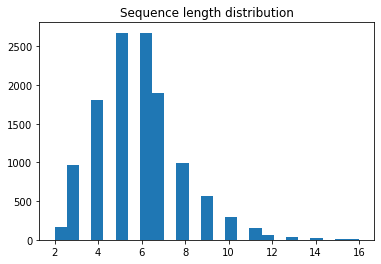

In [24]:
lines = []
for song in df['song']:
    lines.extend(song.split('\n'))
print(lines[::1000])
lines = [line.split(' ') for line in lines]
lines = [['<BOF>'] + line for line in lines if len(line) < 16]
MAX_LENGTH = max(map(len, lines))
print("max length =", MAX_LENGTH)

plt.title('Sequence length distribution')
plt.hist(list(map(len, lines)),bins=25);

print('total {} lines'.format(len(lines)))

In [25]:
tokens = set().union(*lines)

tokens = list(tokens)

num_tokens = len(tokens)
print ('num_tokens = ', num_tokens)
token_to_id = {tokens[i] : i for i in range(len(tokens)) }

num_tokens =  11904


In [26]:
import torch, torch.nn as nn
import torch.nn.functional as F

class CharRNNCell(nn.Module):
    """
    Implement the scheme above as torch module
    """
    def __init__(self, num_tokens=len(tokens), embedding_size=16, rnn_num_units=128):
        super(self.__class__,self).__init__()
        self.num_units = rnn_num_units
        self.embedding = nn.Embedding(num_tokens, embedding_size)
        self.rnn_update = nn.Linear(embedding_size + rnn_num_units, rnn_num_units // 2)
        self.rnn_update2 = nn.Linear(rnn_num_units // 2, rnn_num_units)
        self.rnn_to_logits = nn.Linear(rnn_num_units, num_tokens)
        
    def forward(self, x, h_prev):
        """
        This method computes h_next(x, h_prev) and log P(x_next | h_next)
        We'll call it repeatedly to produce the whole sequence.
        
        :param x: batch of character ids, int64[batch_size]
        :param h_prev: previous rnn hidden states, float32 matrix [batch, rnn_num_units]
        """
        # get vector embedding of x
        x_emb = self.embedding(x)
        
        # compute next hidden state using self.rnn_update
        # hint: use torch.cat(..., dim=...) for concatenation
        h_next = torch.cat((x_emb, h_prev), dim= 1)
        h_next = self.rnn_update(h_next)
        h_next = torch.tanh(h_next)
        h_next = self.rnn_update2(h_next)
        h_next = torch.tanh(h_next)
        
        assert h_next.size() == h_prev.size()
        
        # compute logits for next character probs
        logits = self.rnn_to_logits(h_next) ### YOUR CODE
        
        return h_next, F.log_softmax(logits, -1)
    
    def initial_state(self, batch_size):
        """ return rnn state before it processes first input (aka h0) """
        return torch.zeros(batch_size, self.num_units)

def rnn_loop(char_rnn, batch_ix):
    """
    Computes log P(next_character) for all time-steps in lines_ix
    :param lines_ix: an int32 matrix of shape [batch, time], output of to_matrix(lines)
    """
    batch_size, max_length = batch_ix.size()
    hid_state = char_rnn.initial_state(batch_size)
    logprobs = []

    for x_t in batch_ix.transpose(0,1):
        hid_state, logp_next = char_rnn(x_t, hid_state)  # <-- here we call your one-step code
        logprobs.append(logp_next)
        
    return torch.stack(logprobs, dim=1)

In [27]:
char_rnn = CharRNNCell(embedding_size=300 )
char_rnn.embedding = nn.Embedding(num_tokens, 300)

print(lines[::2000])
print(to_matrix(lines[::2000]))

batch_ix = to_matrix(lines[:5])
batch_ix = torch.tensor(batch_ix, dtype=torch.int64)
logp_seq = rnn_loop(char_rnn, batch_ix)

predictions_logp = logp_seq[:, :-1]
actual_next_tokens = batch_ix[:, 1:]
criterion = torch.nn.NLLLoss()
logp_next = torch.gather(predictions_logp, dim=2, index=actual_next_tokens[:,:,None])
loss = -logp_next.mean()
char_rnn = CharRNNCell(embedding_size=300)
char_rnn.embedding = nn.Embedding(num_tokens, 300)
opt = torch.optim.Adam(char_rnn.parameters())
history = []

[['<BOF>', 'who', 'are', 'you', 'who', 'am', 'i', ''], ['<BOF>', 'в', 'нас', 'уничтожите'], ['<BOF>', 'неотвратим', 'как', 'вер', 'в', 'коммунизм', ''], ['<BOF>', '', 'некрофил', 'некрофилия'], ['<BOF>', '', 'довод', 'даже', 'всяк', 'мелочн', ''], ['<BOF>', 'звер', 'звер', 'звер', 'зверей'], ['<BOF>', '«пионерк', 'из', 'шест', 'класс', 'девочк', 'повеш', 'была', '»']]
[[  406  4297  8766   131  4297  5172  6582     0    36]
 [  406 11764  7848  1195    36    36    36    36    36]
 [  406  4704  2809  6032 11764  9332     0    36    36]
 [  406     0 11780  8757    36    36    36    36    36]
 [  406     0  9459  5815   885  5310     0    36    36]
 [  406  7748  7748  7748   801    36    36    36    36]
 [  406  4132  4085 11367  5294  4313  3378  5888 11538]]


In [28]:
lines[::2000]

[['<BOF>', 'who', 'are', 'you', 'who', 'am', 'i', ''],
 ['<BOF>', 'в', 'нас', 'уничтожите'],
 ['<BOF>', 'неотвратим', 'как', 'вер', 'в', 'коммунизм', ''],
 ['<BOF>', '', 'некрофил', 'некрофилия'],
 ['<BOF>', '', 'довод', 'даже', 'всяк', 'мелочн', ''],
 ['<BOF>', 'звер', 'звер', 'звер', 'зверей'],
 ['<BOF>', '«пионерк', 'из', 'шест', 'класс', 'девочк', 'повеш', 'была', '»']]

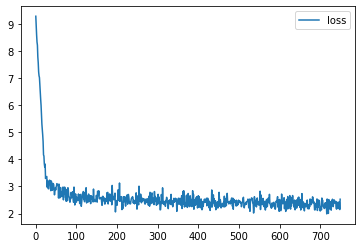

epoch:  14  batch:  49  of  50


In [29]:
from IPython.display import clear_output

bnum = 50
for epoch in range(30):
    for i in range(bnum):
        batch_ix = to_matrix(sample(lines, 32), max_len=MAX_LENGTH)
#         batch_ix = to_matrix(lines[i:i+32], max_len=MAX_LENGTH)
        batch_ix = torch.tensor(batch_ix, dtype=torch.int64)
        logp_seq = rnn_loop(char_rnn, batch_ix)
        logp_seq = logp_seq.permute((0,2,1))
        # compute loss
        # <YOUR CODE>
        target = torch.roll(batch_ix, -1, 1)

        loss = criterion(logp_seq, target)
    #     loss = F.cross_entropy(logits=logp_seq, target=batch_ix)
        opt.zero_grad()

        # train with backprop
        # <YOUR CODE>
        loss.backward()
        opt.step()

        history.append(loss.data.numpy())
        
        
        if True: # (i+1) % 10 == 0:
            clear_output(True)
            plt.plot(history,label='loss')
            plt.legend()
            plt.show()
            print('epoch: ',epoch, ' batch: ',i,' of ', bnum)
        

    assert np.mean(history[:10]) > np.mean(history[-10:]), "RNN didn't converge."

In [30]:
def generate_sample(char_rnn, seed_phrase=' ', max_length=MAX_LENGTH, temperature=1.0):
    '''
    The function generates text given a phrase of length at least SEQ_LENGTH.
    :param seed_phrase: prefix characters. The RNN is asked to continue the phrase
    :param max_length: maximum output length, including seed_phrase
    :param temperature: coefficient for sampling.  higher temperature produces more chaotic outputs,
                        smaller temperature converges to the single most likely output
    '''
    
    x_sequence = [token_to_id[token] for token in seed_phrase]
    x_sequence = torch.tensor([x_sequence], dtype=torch.int64)
    hid_state = char_rnn.initial_state(batch_size=1)
    
    #feed the seed phrase, if any
    for i in range(len(seed_phrase) - 1):
        hid_state, _ = char_rnn(x_sequence[:, i], hid_state)
    
    #start generating
    for _ in range(max_length - len(seed_phrase)):
        hid_state, logp_next = char_rnn(x_sequence[:, -1], hid_state)
        p_next = F.softmax(logp_next / temperature, dim=-1).data.numpy()[0]
        
        # sample next token and push it back into x_sequence
        next_ix = np.random.choice(num_tokens,p=p_next)
        next_ix = torch.tensor([[next_ix]], dtype=torch.int64)
        x_sequence = torch.cat([x_sequence, next_ix], dim=1)
        
    return ' '.join([tokens[ix] for ix in x_sequence.data.numpy()[0]])

In [48]:
for _ in range(10):
    print(generate_sample(char_rnn, seed_phrase = ['<BOF>'], temperature=50))

ValueError: not enough values to unpack (expected 2, got 1)

In [42]:
token_to_id['жалабн']


2410

### More seriously

What we just did is a manual low-level implementation of RNN. While it's cool, i guess you won't like the idea of re-writing it from scratch on every occasion. 

As you might have guessed, torch has a solution for this. To be more specific, there are two options:
* `nn.RNNCell(emb_size, rnn_num_units)` - implements a single step of RNN just like you did. Basically concat-linear-tanh
* `nn.RNN(emb_size, rnn_num_units` - implements the whole rnn_loop for you.

There's also `nn.LSTMCell` vs `nn.LSTM`, `nn.GRUCell` vs `nn.GRU`, etc. etc.

In this example we'll rewrite the char_rnn and rnn_loop using high-level rnn API.

In [34]:
class CharRNNLoop(nn.Module):
    def __init__(self, num_tokens=num_tokens, emb_size=16, rnn_num_units=64):
        super(self.__class__, self).__init__()
        self.emb = nn.Embedding(num_tokens, emb_size)
        self.rnn = nn.RNN(emb_size, rnn_num_units, batch_first=True)
        self.hid_to_logits = nn.Linear(rnn_num_units, num_tokens)
        
    def forward(self, x):
        h_seq, _ = self.rnn(self.emb(x))
        next_logits = self.hid_to_logits(h_seq)
        next_logp = F.log_softmax(next_logits, dim=-1)
        return next_logp
    
model = CharRNNLoop()

In [35]:
# the model applies over the whole sequence
batch_ix = to_matrix(sample(lines, 32), max_len=MAX_LENGTH)
batch_ix = torch.tensor(batch_ix, dtype=torch.int64)

logp_seq = model(batch_ix)

# compute loss. This time we use nll_loss with some duct tape
loss = F.nll_loss(logp_seq[:, :-1].contiguous().view(-1, num_tokens), 
                  batch_ix[:, 1:].contiguous().view(-1))

loss.backward()

Here's another example

In [36]:
import torch, torch.nn as nn
import torch.nn.functional as F

class CharLSTMCell(nn.Module):
    """
    Implements something like CharRNNCell, but with LSTM
    """
    def __init__(self, num_tokens=len(tokens), embedding_size=16, rnn_num_units=64):
        super(self.__class__,self).__init__()
        self.num_units = rnn_num_units
        self.emb = nn.Embedding(num_tokens, embedding_size)
        self.lstm = nn.LSTMCell(embedding_size, rnn_num_units)
        self.rnn_to_logits = nn.Linear(rnn_num_units, num_tokens)
        
    def forward(self, x, prev_state):
        (prev_h, prev_c) = prev_state
        (next_h, next_c) = self.lstm(self.emb(x), (prev_h, prev_c))
        logits = self.rnn_to_logits(next_h)
        
        return (next_h, next_c), F.log_softmax(logits, -1)
    
    def initial_state(self, batch_size):
        """ LSTM has two state variables, cell and hid """
        return torch.zeros(batch_size, self.num_units), torch.zeros(batch_size, self.num_units)
    
char_lstm = CharLSTMCell()

In [37]:
# the model applies over the whole sequence
batch_ix = to_matrix(sample(lines, 32), max_len=MAX_LENGTH)
batch_ix = torch.tensor(batch_ix, dtype=torch.int64)

logp_seq = rnn_loop(char_lstm, batch_ix)

# compute loss. This time we use nll_loss with some duct tape
loss = F.nll_loss(logp_seq[:, :-1].contiguous().view(-1, num_tokens), 
                  batch_ix[:, 1:].contiguous().view(-1))

loss.backward()

__Additional 4 scores bonus quest:__ implement a model that uses 2 LSTM layers (the second lstm uses the first as input) and train it on your data.

In [38]:
############################################################################################

In [94]:
import torch, torch.nn as nn
import torch.nn.functional as F

class CharRNNCell(nn.Module):
    """
    Implement the scheme above as torch module
    """
    def __init__(self, num_tokens=len(tokens), embedding_size=300, rnn_num_units=128):
        super(self.__class__,self).__init__()
        self.num_units = rnn_num_units
        self.emb = nn.Embedding(num_tokens, embedding_size)
        
        self.lstm1 = nn.LSTMCell(embedding_size, rnn_num_units)
        self.lstm2 = nn.LSTMCell(rnn_num_units, rnn_num_units)

        self.rnn_to_logits = nn.Linear(rnn_num_units, num_tokens)
        self.rnn_to_logits2 = nn.Linear(rnn_num_units, num_tokens)
        
    def random_choice(proba):
        return np.random.choice(num_tokens, p=proba)
        
    def forward(self, x, prev_state1, prev_state2):
        (prev_h, prev_c) = prev_state1
        (prev_h2, prev_c2) = prev_state2
        (next_h1, next_c1) = self.lstm1(self.emb(x), (prev_h, prev_c))
        (next_h2, next_c2) = self.lstm2(next_h1, (prev_h2, prev_c2))
        logits2 = self.rnn_to_logits2(next_h2)

        return (next_h1, next_c1), (next_h2, next_c2), F.log_softmax(logits2, -1)

    def initial_state(self, batch_size):
        """ return rnn state before it processes first input (aka h0) """
        return (torch.zeros(batch_size, self.num_units), \
                torch.zeros(batch_size, self.num_units)), \
                (torch.zeros(batch_size, self.num_units), \
                torch.zeros(batch_size, self.num_units))

def rnn_loop(char_rnn, batch_ix):
    """
    Computes log P(next_character) for all time-steps in lines_ix
    :param lines_ix: an int32 matrix of shape [batch, time], output of to_matrix(lines)
    """
    batch_size, max_length = batch_ix.size()
    hid_state1, hid_state2 = char_rnn.initial_state(batch_size)
    logprobs = []

    for x_t in batch_ix.transpose(0,1):
        hid_state1, hid_state2, logp_next = char_rnn2(x_t, hid_state1, hid_state2)  # <-- here we call your one-step code
        logprobs.append(logp_next)
        
    return torch.stack(logprobs, dim=1)

In [95]:
char_rnn2 = CharRNNCell(embedding_size=300 )
char_rnn.embedding = nn.Embedding(num_tokens, 300)

print(lines[::2000])
print(to_matrix(lines[::2000]))

batch_ix = to_matrix(lines[:5])
batch_ix = torch.tensor(batch_ix, dtype=torch.int64)
logp_seq = rnn_loop(char_rnn2, batch_ix)

predictions_logp = logp_seq[:, :-1]
actual_next_tokens = batch_ix[:, 1:]
criterion = torch.nn.NLLLoss()
logp_next = torch.gather(predictions_logp, dim=2, index=actual_next_tokens[:,:,None])
loss = -logp_next.mean()
char_rnn2 = CharRNNCell(embedding_size=300)
char_rnn2.embedding = nn.Embedding(num_tokens, 300)
opt = torch.optim.Adam(char_rnn2.parameters())
history = []

[['<BOF>', 'who', 'are', 'you', 'who', 'am', 'i', ''], ['<BOF>', 'в', 'нас', 'уничтожите'], ['<BOF>', 'неотвратим', 'как', 'вер', 'в', 'коммунизм', ''], ['<BOF>', '', 'некрофил', 'некрофилия'], ['<BOF>', '', 'довод', 'даже', 'всяк', 'мелочн', ''], ['<BOF>', 'звер', 'звер', 'звер', 'зверей'], ['<BOF>', '«пионерк', 'из', 'шест', 'класс', 'девочк', 'повеш', 'была', '»']]
[[  406  4297  8766   131  4297  5172  6582     0    36]
 [  406 11764  7848  1195    36    36    36    36    36]
 [  406  4704  2809  6032 11764  9332     0    36    36]
 [  406     0 11780  8757    36    36    36    36    36]
 [  406     0  9459  5815   885  5310     0    36    36]
 [  406  7748  7748  7748   801    36    36    36    36]
 [  406  4132  4085 11367  5294  4313  3378  5888 11538]]


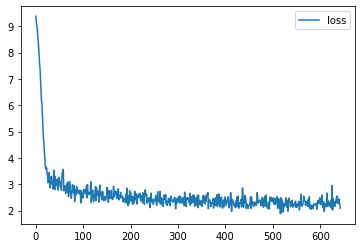

epoch:  12  batch:  42  of  50


In [ ]:
from IPython.display import clear_output

bnum = 50
for epoch in range(20):
    for i in range(bnum):
        batch_ix = to_matrix(sample(lines, 32), max_len=MAX_LENGTH)
#         batch_ix = to_matrix(lines[i:i+32], max_len=MAX_LENGTH)
        batch_ix = torch.tensor(batch_ix, dtype=torch.int64)
        logp_seq = rnn_loop(char_rnn2, batch_ix)
        logp_seq = logp_seq.permute((0,2,1))
        # compute loss
        # <YOUR CODE>
        target = torch.roll(batch_ix, -1, 1)

        loss = criterion(logp_seq, target)
    #     loss = F.cross_entropy(logits=logp_seq, target=batch_ix)
        opt.zero_grad()

        # train with backprop
        # <YOUR CODE>
        loss.backward()
        opt.step()

        history.append(loss.data.numpy())
        
        
        if True: # (i+1) % 10 == 0:
            clear_output(True)
            plt.plot(history,label='loss')
            plt.legend()
            plt.show()
            print('epoch: ',epoch, ' batch: ',i,' of ', bnum)
        

    assert np.mean(history[:10]) > np.mean(history[-10:]), "RNN didn't converge."

In [63]:
def generate_sample(char_rnn, seed_phrase=' ', max_length=MAX_LENGTH, temperature=1.0):
    '''
    The function generates text given a phrase of length at least SEQ_LENGTH.
    :param seed_phrase: prefix characters. The RNN is asked to continue the phrase
    :param max_length: maximum output length, including seed_phrase
    :param temperature: coefficient for sampling.  higher temperature produces more chaotic outputs,
                        smaller temperature converges to the single most likely output
    '''
    
    x_sequence = [token_to_id[token] for token in seed_phrase]
    x_sequence = torch.tensor([x_sequence], dtype=torch.int64)
    hid_state = char_rnn2.initial_state(batch_size=1)
    
    #feed the seed phrase, if any
    for i in range(len(seed_phrase) - 1):
        hid_state, _ = char_rnn2(x_sequence[:, i], hid_state)
    
    #start generating
    for _ in range(max_length - len(seed_phrase)):
        hid_state, logp_next = char_rnn2(x_sequence[:, -1], hid_state)
        p_next = F.softmax(logp_next / temperature, dim=-1).data.numpy()[0]
        
        # sample next token and push it back into x_sequence
        next_ix = np.random.choice(num_tokens,p=p_next)
        next_ix = torch.tensor([[next_ix]], dtype=torch.int64)
        x_sequence = torch.cat([x_sequence, next_ix], dim=1)
        
    return ' '.join([tokens[ix] for ix in x_sequence.data.numpy()[0]])

In [64]:
for _ in range(10):
    print(generate_sample(char_rnn, seed_phrase = ['<BOF>'], temperature=50))

<BOF> зло тронул блест соб зори ручн безграничн весел захлеб посред любви» резне-кровав канавк принесу» очист
<BOF> ремесла море ерунд рукаве жечь…м беляш маленьк бетон государства клевещ сумел молодежь трусы бана взявш
<BOF> представлений обруш стел гопят допог внутр нетлен хрустят коров гибельн промокш железным побегать праздник заколоч
<BOF> меж перепута посадок крошечн сал схож фрак оно-н тонк кос буд ста ощущение s повел
<BOF> слава-звонк миллиарды кит тверж котенка» гергесинск хар идеальн спал долго-долго вдоль стрекоз жадност мен деревенск
<BOF> тракторн отступа ненастн желудочн гостях капита даеш колхоз основ здорово— зряч школ закопа предлага спача
<BOF> пластинк обпетитны руками вздорн все-ж залеп стране распростран «ураа перрона головн машинальн отвоевыва «открове» день)
<BOF> гадать мал виновн грянет швыря подарк вперв отдохнут почему-т раю шкелет свищ охраня певец ползущих
<BOF> кабук них заперевш сдела почетное выведа сказ парижск убива заскрип дурн нар поворот ботинком п